In [1]:
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


INPUT_FIELDS = [
    'CRITICALITY',
    'CONNECTIVITY',
    'RELIABILITY',
    'IMPORTANCE',
    'PROVIDED_INTERFACE',
    'REQUIRED_INTERFACE',
    'ADT',
    ' PMax',
    'alpha',
    'In Use REPLICA',
    'LOAD',
]
OUTPUT_FIELD = 'OPTIMAL_UTILITY'

data = pd.read_csv('../data/TrainingmRUBiS_Theta0.05_NonStationary.csv')[INPUT_FIELDS + [OUTPUT_FIELD]].dropna()
data['beta'] = data.apply(lambda row: row['PROVIDED_INTERFACE'] + (0 if row['PROVIDED_INTERFACE'] >= 2 else 1), axis=1)
data['Combined'] = data['RELIABILITY'] * data['CRITICALITY'] * data['IMPORTANCE'] * data['beta'] * data[' PMax'] * np.tanh(data['alpha'] * data['In Use REPLICA'] / data['LOAD']) *  (data['REQUIRED_INTERFACE'] + 1) - 10 * data['ADT']
data

,CRITICALITY,CONNECTIVITY,RELIABILITY,IMPORTANCE,PROVIDED_INTERFACE,REQUIRED_INTERFACE,ADT,PMax,alpha,In Use REPLICA,LOAD,OPTIMAL_UTILITY,beta,Combined
0,12.0,2,0.5,22.0,1,1,1.160442,5.886177,77.141379,8.0,484.0,7519.076309,2.0,2646.161723
1,30.0,2,0.5,22.0,1,1,1.488639,11.295025,99.098217,6.0,133.0,36509.949351,2.0,14890.644192
2,20.0,2,0.5,22.0,1,1,1.006633,9.717122,137.960688,10.0,338.0,20936.036775,2.0,8536.129632
3,30.0,2,0.5,22.0,1,1,1.488639,11.295025,99.098217,6.0,133.0,35853.737398,2.0,14890.644192
4,21.0,5,0.5,22.0,5,0,1.329731,16.947828,97.046334,14.0,336.0,47950.348693,5.0,19549.410637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,23.0,4,0.5,22.0,0,4,1.296817,12.901919,123.488873,7.0,330.0,32472.635152,1.0,16135.677235
884,12.0,17,0.5,22.0,16,1,1.160442,5.886177,77.141379,10.0,75.0,27959.282005,16.0,24851.606161
885,23.0,11,0.5,22.0,10,1,1.055559,5.798189,73.839639,12.0,403.0,34500.447546,10.0,28614.782772
886,23.0,11,0.5,22.0,10,1,1.055559,5.798189,73.839639,12.0,403.0,34713.323549,10.0,28614.782772


<AxesSubplot:ylabel='OPTIMAL_UTILITY'>

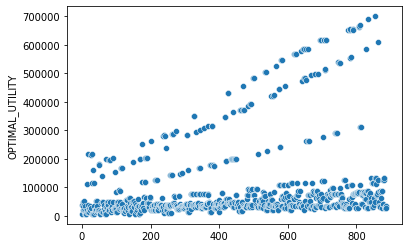

In [2]:
sn.scatterplot(x=data.index, y=OUTPUT_FIELD, data=data)

<AxesSubplot:ylabel='Combined'>

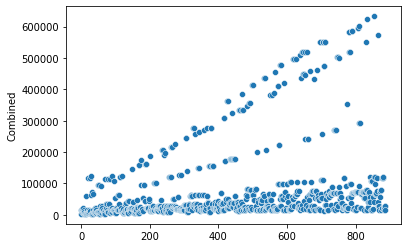

In [3]:
sn.scatterplot(x=data.index, y='Combined', data=data)

<AxesSubplot:xlabel='Combined', ylabel='OPTIMAL_UTILITY'>

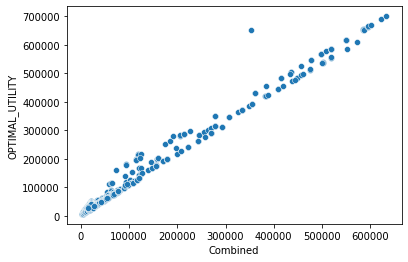

In [4]:
sn.scatterplot(x='Combined', y=OUTPUT_FIELD, data=data)

In [5]:
data['utility_per_combined'] = data['OPTIMAL_UTILITY']/data['Combined']

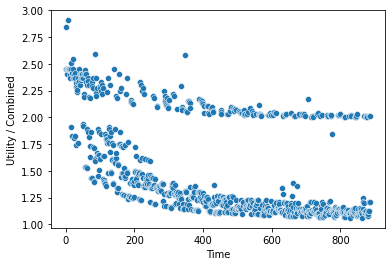

In [6]:
sn.scatterplot(x=data.index, y='utility_per_combined', data=data)
plt.xlabel("Time")
plt.ylabel("Utility / Combined")
plt.savefig('scatter.png', dpi=300, facecolor='white', edgecolor='none')

In [7]:
def train_ridge(X, y):
    ridge = Ridge()
    ridge.fit(X, y)
    return ridge

<AxesSubplot:>

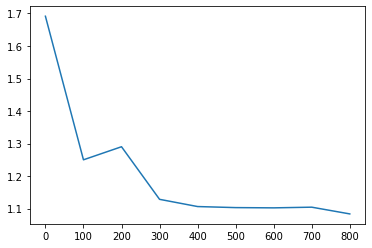

In [8]:
parameters = [train_ridge(data[['Combined']].iloc[i:i+100], data[OUTPUT_FIELD].iloc[i:i+100]).coef_[0] for i in range(0, len(data), 100)]
sn.lineplot(x=range(0, len(data), 100), y=parameters)

<AxesSubplot:>

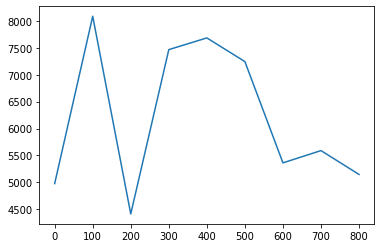

In [9]:
intercepts = [train_ridge(data[['Combined']].iloc[i:i+100], data[OUTPUT_FIELD].iloc[i:i+100]).intercept_ for i in range(0, len(data), 100)]
sn.lineplot(x=range(0, len(data), 100), y=intercepts)

# Nonstationarity
## Idea 1: Assuming a linear drift
- Add time to the set of features
- Let linear regression learn the parameter for the drift (shift/time)

## Idea 2: Assuming some kind of drift or seasonality
- Stationarize time series using Difference Transform (https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/)
- https://pypi.org/project/stationarizer/

## **Idea 3: No assumptions about the nature of the nonstationarity**
- Train initial model, measure R^2 on test set
- Monitor R^2 for all observations that were added later
- If R^2 becomes too low, train a new model using the most recent observations, monitor R^2 for all observations that were added later


<AxesSubplot:>

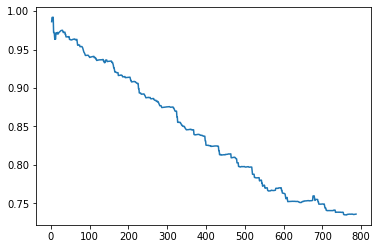

In [10]:
initial_batch = data.iloc[0:100]
online_data = data.iloc[100:]

ridge = train_ridge(initial_batch.drop([OUTPUT_FIELD], axis=1), initial_batch[OUTPUT_FIELD])
test_data = pd.DataFrame(columns=initial_batch.columns)
scores = []
for record in online_data.iloc:
    test_data = test_data.append(record)
    if len(test_data) > 2:
        scores.append(ridge.score(test_data.drop([OUTPUT_FIELD], axis=1), test_data[OUTPUT_FIELD]))
    else:
        scores.append(None)

sn.lineplot(x=range(len(online_data)), y=scores)

In [11]:
def train_ridge_online(initial_batch, online_data, threshold):
    ridge = train_ridge(initial_batch.drop([OUTPUT_FIELD], axis=1), initial_batch[OUTPUT_FIELD])
    test_data = pd.DataFrame(columns=initial_batch.columns)
    for record in online_data.iloc:
        test_data = test_data.append(record)
        if len(test_data) > 2:
            score = ridge.score(test_data.drop([OUTPUT_FIELD], axis=1), test_data[OUTPUT_FIELD])
            if score < threshold:
                ridge = train_ridge(test_data.drop([OUTPUT_FIELD], axis=1), test_data[OUTPUT_FIELD])
                test_data = pd.DataFrame(columns=initial_batch.columns)
            yield score
        else:
            yield None

<AxesSubplot:>

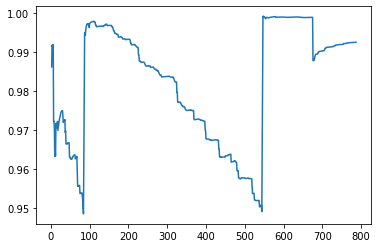

In [12]:
sn.lineplot(
    x=range(len(online_data)), 
    y=train_ridge_online(
        initial_batch, 
        online_data, 
        threshold=0.95
    )
)

<AxesSubplot:>

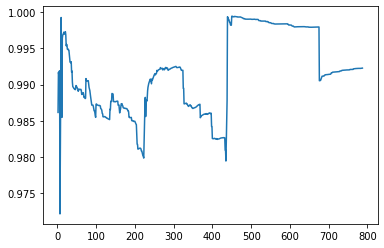

In [13]:
sn.lineplot(
    x=range(len(online_data)), 
    y=train_ridge_online(
        initial_batch, 
        online_data, 
        threshold=0.98
    )
)

In [14]:
class SGDRidge(SGDRegressor):
    def __init__(self):
        self.scaler = StandardScaler()
        super().__init__(loss='squared_loss', penalty='l2', max_iter=1000000)
        
    def transfer(self, X, y):
        ridge = SGDRidge()
        ridge.fit(X, y, coef_init=self.coef_, intercept_init=self.intercept_)
        return ridge
    
    def replace(self, X, y):
        ridge = SGDRidge()
        ridge.fit(X, y)
        return ridge
        
    def fit(self, X, *args, **kwargs):
        self.scaler.fit(X)
        return super().fit(self.scaler.transform(X), *args, **kwargs)
        
    def score(self, X, *args, **kwargs):
        return super().score(self.scaler.transform(X), *args, **kwargs)
    
    @staticmethod
    def train_online(initial_batch, online_data, threshold=0.98, min_test_size=40, mode='replace'):
        ridge = SGDRidge()
        ridge.fit(initial_batch.drop([OUTPUT_FIELD], axis=1), initial_batch[OUTPUT_FIELD])
        test_data = pd.DataFrame(columns=initial_batch.columns)
        for record in online_data.iloc:
            test_data = test_data.append(record)
            if len(test_data) >= min_test_size:
                score = ridge.score(test_data.drop([OUTPUT_FIELD], axis=1), test_data[OUTPUT_FIELD])
                if score < threshold:
                    if mode == 'replace':
                        ridge = ridge.replace(test_data.drop([OUTPUT_FIELD], axis=1), test_data[OUTPUT_FIELD])
                    elif mode == 'transfer':
                        ridge = ridge.transfer(test_data.drop([OUTPUT_FIELD], axis=1), test_data[OUTPUT_FIELD])
                    else:
                        raise ValueError(f'Invalid mode: {mode}')
                    test_data = pd.DataFrame(columns=initial_batch.columns)
                yield score
            else:
                yield None

CPU times: user 2.65 s, sys: 70.8 ms, total: 2.72 s
Wall time: 2.92 s


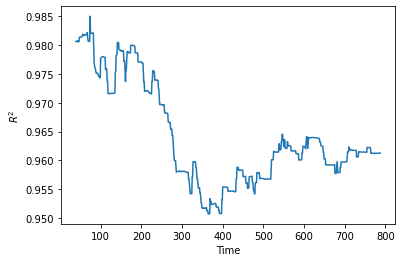

In [15]:
%%time
sn.lineplot(
    x=range(len(online_data)), 
    y=SGDRidge.train_online(
        initial_batch, 
        online_data, 
        threshold=0
    )
)

plt.xlabel("Time")
plt.ylabel("$R^2$")
plt.savefig('non-stationary.png', dpi=300, facecolor='white', edgecolor='none')

CPU times: user 3.08 s, sys: 45.5 ms, total: 3.13 s
Wall time: 3.32 s


<AxesSubplot:>

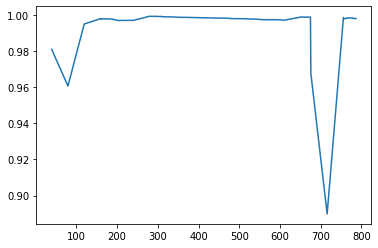

In [16]:
%%time
sn.lineplot(
    x=range(len(online_data)), 
    y=SGDRidge.train_online(
        initial_batch, 
        online_data, 
        threshold=0.997,
        mode='replace'
    )
)

CPU times: user 2 s, sys: 25.6 ms, total: 2.02 s
Wall time: 2.1 s


<AxesSubplot:>

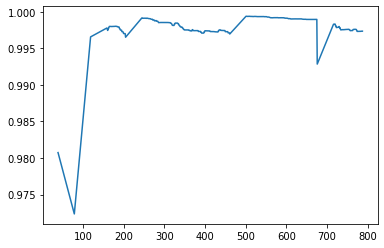

In [17]:
%%time
sn.lineplot(
    x=range(len(online_data)), 
    y=SGDRidge.train_online(
        initial_batch, 
        online_data, 
        threshold=0.997,
        mode='transfer'
    )
)

In [38]:
class SGDRidgeWindowed(SGDRidge):
    @staticmethod
    def train_online(initial_batch, online_data, threshold=0.98, min_test_size=40, mode='replace'):
        ridge = SGDRidge()
        ridge.fit(initial_batch.drop([OUTPUT_FIELD], axis=1), initial_batch[OUTPUT_FIELD])
        test_data = initial_batch.copy()
        for record in online_data.iloc:
            test_data = test_data.append(record)
            test_data_window = test_data.iloc[min_test_size:]
            window_features = test_data_window.drop([OUTPUT_FIELD], axis=1)
            window_labels = test_data_window[OUTPUT_FIELD]
            score = ridge.score(window_features, window_labels)
            retrained = False
            if score < threshold:
                retrained = True
                if mode == 'replace':
                    ridge = ridge.replace(window_features, window_labels)
                elif mode == 'transfer':
                    ridge = ridge.transfer(window_features, window_labels)
                else:
                    raise ValueError(f'Invalid mode: {mode}')
                score = ridge.score(window_features, window_labels)
            yield (score, retrained)

CPU times: user 2.44 s, sys: 47.8 ms, total: 2.49 s
Wall time: 2.53 s


<AxesSubplot:>

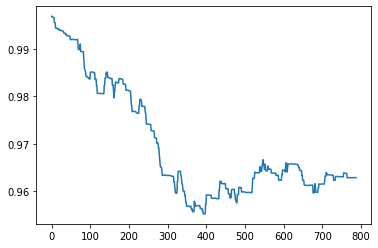

In [39]:
%%time
scores, _ = zip(
    *SGDRidgeWindowed.train_online(
            initial_batch, 
            online_data, 
            threshold=0
        )
)
sn.lineplot(
    x=range(len(online_data)), 
    y=scores
)

CPU times: user 4.98 s, sys: 76.6 ms, total: 5.06 s
Wall time: 5.16 s


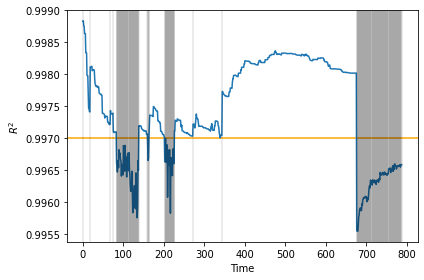

In [51]:
%%time
scores, retrained = zip(
    *SGDRidgeWindowed.train_online(
        initial_batch, 
        online_data, 
        threshold=0.997
    )
)
plt.axhline(y=0.997, color='orange')
sn.lineplot(
    x=range(len(online_data)), 
    y=scores
)
for i, was_retraining in enumerate(retrained):
    if was_retraining:
        plt.axvline(x=i, color=(0, 0, 0, 0.1))
plt.xlabel("Time")
plt.ylabel("$R^2$")
plt.tight_layout()
plt.savefig('replace.png', dpi=300, facecolor='white', edgecolor='none')

CPU times: user 3.77 s, sys: 89 ms, total: 3.85 s
Wall time: 4.01 s


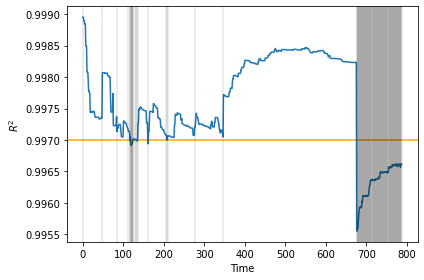

In [54]:
%%time
scores, retrained = zip(
    *SGDRidgeWindowed.train_online(
        initial_batch, 
        online_data, 
        threshold=0.997,
        mode='transfer'
    )
)
plt.axhline(y=0.997, color='orange')
sn.lineplot(
    x=range(len(online_data)), 
    y=scores
)
for i, was_retraining in enumerate(retrained):
    if was_retraining:
        plt.axvline(x=i, color=(0, 0, 0, 0.1))
plt.xlabel("Time")
plt.ylabel("$R^2$")
plt.tight_layout()
plt.savefig('transfer.png', dpi=300, facecolor='white', edgecolor='none')